Exercise 1 
In this chapter I claim that analyze1 takes time proportional to n3 and analyze2 takes time proportional to n2. To see if that’s true, run them on a range of input sizes and time them. In Jupyter, you can use the “magic command” %timeit.
If you plot run time versus input size on a log-log scale, you should get a straight line with slope 3 for analyze1 and slope 2 for analyze2.
You also might want to test dct_iv and scipy.fftpack.dct.
在本章中，我聲稱analyzer1花費的時間與n3成正比，analyze2花的時間與n2成正比。要查看是否正確，請在一系列輸入大小上運行它們併計時。在Jupyter中，您可以使用“魔術命令”％timeit。
如果在對數對數標度上繪製運行時間與輸入大小的關係，則應該獲得一條直線，其中analyzer1的斜率為3，analyze2為斜率2。
您可能還需要測試dct_iv和scipy.fftpack.dct。

In [7]:
import numpy as np
import matplotlib.pyplot as plt

from thinkdsp import decorate

我將從噪聲信號和2的冪次方數組開始

In [8]:
from thinkdsp import UncorrelatedGaussianNoise

signal = UncorrelatedGaussianNoise()
noise = signal.make_wave(duration=1.0, framerate=16384)
noise.ys.shape

(16384,)

以下函數從時序實驗中獲取一系列結果，繪製結果並擬合一條直線。

In [9]:
from scipy.stats import linregress

loglog = dict(xscale='log', yscale='log') # 取loglog對數

def plot_bests(ns, bests):    
    plt.plot(ns, bests)
    decorate(**loglog)
    
    x = np.log(ns)
    y = np.log(bests)
    t = linregress(x,y)
    slope = t[0]

    return slope

分析餘弦和返回幅度的混合。
適用於M不正交的一般情況

In [10]:
PI2 = np.pi * 2

def analyze1(ys, fs, ts):

    args = np.outer(ts, fs)
    M = np.cos(PI2 * args)
    amps = np.linalg.solve(M, ys)
    return amps # 回傳振福

In [11]:
def run_speed_test(ns, func):
    results = []
    for N in ns:
        print(N)
        ts = (0.5 + np.arange(N)) / N
        freqs = (0.5 + np.arange(N)) / 2
        ys = noise.ys[:N]
        result = %timeit -r1 -o func(ys, freqs, ts)
        results.append(result)
        
    bests = [result.best for result in results]
    return bests

analyze1的結果。

In [12]:
ns = 2 ** np.arange(6, 13)
ns

array([  64,  128,  256,  512, 1024, 2048, 4096], dtype=int32)

64
268 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1000 loops each)
128
823 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1000 loops each)
256
4.62 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
512
20.7 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
1024
94.2 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
2048
403 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
4096
1.68 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


2.145682103879955

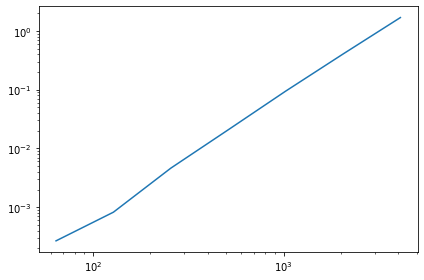

In [13]:
bests = run_speed_test(ns, analyze1)
plot_bests(ns, bests)

估計的斜率接近2，而不是預期的3。一種可能性是，在此陣列大小範圍內，np.linalg.solve的性能幾乎是平方的。

analyze2的結果。

In [14]:
def analyze2(ys, fs, ts):

    args = np.outer(ts, fs)
    M = np.cos(PI2 * args)
    amps = np.dot(M, ys) / 2
    return amps

64
132 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10000 loops each)
128
415 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1000 loops each)
256
2.55 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
512
12.4 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
1024
48.1 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
2048
205 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
4096
772 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


2.1306936222550137

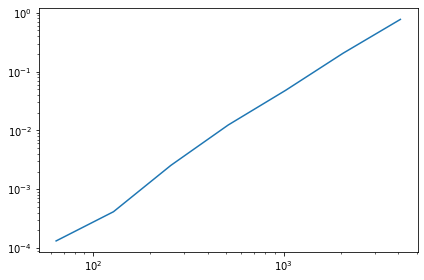

In [15]:
bests2 = run_speed_test(ns, analyze2)
plot_bests(ns, bests2)

如預期的那樣，analyze2的結果呈一條直線，估計斜率接近於2。

scipy.fftpack.dct的結果

In [16]:
import scipy.fftpack

def scipy_dct(ys, freqs, ts):
    return scipy.fftpack.dct(ys, type=3)

64
15 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100000 loops each)
128
16.3 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100000 loops each)
256
17.7 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100000 loops each)
512
21.3 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10000 loops each)
1024
33.4 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10000 loops each)
2048
44.5 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10000 loops each)
4096
81.7 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10000 loops each)


0.3978986518995551

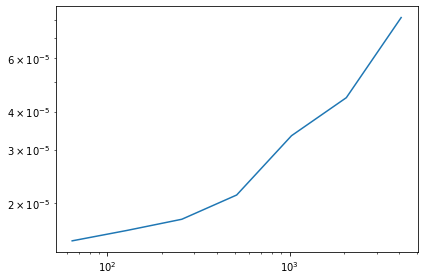

In [17]:
bests3 = run_speed_test(ns, scipy_dct)
plot_bests(ns, bests3)

dct的這種實現甚至更快。這條線是彎曲的，這意味著要么我們還沒有看到過漸近行為，要么漸進行為不是simple的簡單指數。實際上，正如我們很快將看到的，運行時間與𝑛log𝑛成正比。

下面的圖將三個結合

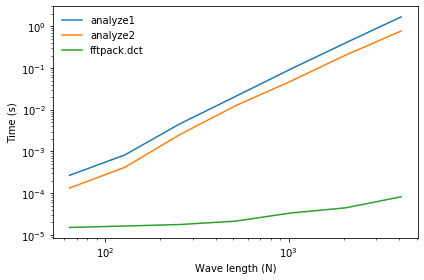

In [18]:
plt.plot(ns, bests, label='analyze1')
plt.plot(ns, bests2, label='analyze2')
plt.plot(ns, bests3, label='fftpack.dct')
decorate(xlabel='Wave length (N)', ylabel='Time (s)', **loglog)